In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt


# Load data
data = pd.read_excel('data/data 260225.xlsx')

# Display the first few rows
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Check data types
print(data.info())

   No.                   Reference No. Category  \
0    1  RTS-MRTS-PKG2A-ICQC-NCR-000005  Quality   
1    2  RTS-MRTS-PKG2A-ICQC-NCR-000006  Quality   
2    3  RTS-MRTS-PKG2A-ICQC-NCR-000007   Safety   
3    4  RTS-MRTS-PKG2A-ICQC-NCR-000008      Env   
4    5  RTS-MRTS-PKG2A-ICQC-NCR-000009      Env   

                      Description of Non-Conformance Date Issued  \
0  Deformed reinforcement result of poor welding ...  2022-06-14   
1  28 nos. of bored piles reinforcement cages ins...  2022-06-14   
2  It was found that the person in-charge (Radius...  2022-06-30   
3  It was observed that the TSS reading for water...  2022-06-30   
4  It was found that empty chemical containers st...  2022-06-30   

  Expected Reply Date Actual Reply Date  Respond Period  \
0          2022-06-28        2022-06-22  Within 14 days   
1          2022-06-28        2022-06-23  Within 14 days   
2          2022-07-14        2022-07-15   After 14 days   
3          2022-07-14        2022-07-15   After 

In [4]:
#3. Data Cleaning and Preprocessing

In [5]:
# Drop unnecessary columns
data = data.drop(['No.', 'Reference No.', 'Description of Non-Conformance'], axis=1)

# Convert date columns to datetime
date_columns = ['Date Issued', 'Expected Reply Date', 'Actual Reply Date', 'Expected Completion Date', 'Closed Date']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], format='%d/%m/%Y', errors='coerce')

# Calculate NCR Closure Duration
data['NCR Closure Duration'] = (data['Closed Date'] - data['Date Issued']).dt.days

# Calculate Reply Delay
data['Reply_Delay'] = (data['Actual Reply Date'] - data['Expected Reply Date']).dt.days

# Handle missing values in NCR Closure Duration
data['NCR Closure Duration'] = data['NCR Closure Duration'].fillna(-1)

# Create Recurrence column
data['Recurrence'] = data.duplicated(subset=['Nature of NCR', 'Package'], keep=False)
data['Recurrence'] = data['Recurrence'].map({True: 'Yes', False: 'No'})

# Calculate Recurrence Rate
recurrence_rate = data.groupby(['Nature of NCR', 'Package'])['Recurrence'].apply(lambda x: (x == 'Yes').mean()).reset_index()
recurrence_rate.rename(columns={'Recurrence': 'Recurrence_Rate'}, inplace=True)
data = data.merge(recurrence_rate, on=['Nature of NCR', 'Package'], how='left')

# Drop rows with missing values in key columns
data.dropna(subset=['Nature of NCR', 'Package'], inplace=True)

In [6]:
#4. Feature Engineering
#Prepare features for machine learning models.

In [7]:
# One-hot encode categorical columns
categorical_cols = ['Category', 'Status', 'Nature of NCR', 'Package', 'Contractor']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Separate features and targets
X = data.drop(['NCR Closure Duration', 'Recurrence'], axis=1)
y_duration = data['NCR Closure Duration']
y_recurrence = data['Recurrence']

# Encode Recurrence target column
label_encoder = LabelEncoder()
y_recurrence = label_encoder.fit_transform(y_recurrence)

In [8]:
#5. Split Data into Training and Testing Sets
#Split the data for both regression and classification tasks.

In [9]:
# Split data for regression (NCR Closure Duration)
X_train, X_test, y_train_duration, y_test_duration = train_test_split(X, y_duration, test_size=0.2, random_state=42)

# Split data for classification (Recurrence)
X_train, X_test, y_train_recurrence, y_test_recurrence = train_test_split(X, y_recurrence, test_size=0.2, random_state=42)

In [10]:
#6. Train and Evaluate Regression Model (NCR Closure Duration)
#Train a Random Forest Regressor to predict the NCR closure duration.

In [11]:
columns_to_drop = [
    'Respond Period',
    'NCR Aging from Expected Completion date',
    'Closed NCR Effectiveness Verification Status',
    'Date Issued',
    'Expected Reply Date',
    'Actual Reply Date',
    'Expected Completion Date',
    'Closed Date'
]

# Only drop columns if they exist
columns_to_drop_train = [col for col in columns_to_drop if col in X_train.columns]
columns_to_drop_test = [col for col in columns_to_drop if col in X_test.columns]

X_train = X_train.drop(columns=columns_to_drop_train)
X_test = X_test.drop(columns=columns_to_drop_test)


In [12]:
# Train Random Forest Regressor
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train_duration)

# Predict on test data
y_pred_duration = regressor.predict(X_test)

# Evaluate regression model
mae = mean_absolute_error(y_test_duration, y_pred_duration)
print(f"Mean Absolute Error (MAE) for NCR Closure Duration: {mae:.2f}")

Mean Absolute Error (MAE) for NCR Closure Duration: 1.25


In [13]:
#7. Train and Evaluate Classification Model (Recurrence)
#Train a Random Forest Classifier to predict recurrence.

In [14]:
# Train Random Forest Classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train_recurrence)

# Predict on test data
y_pred_recurrence = classifier.predict(X_test)

# Evaluate classification model
accuracy = accuracy_score(y_test_recurrence, y_pred_recurrence)
print(f"Accuracy for Recurrence Prediction: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test_recurrence, y_pred_recurrence))

Accuracy for Recurrence Prediction: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        65

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



In [15]:
#8. Visualize Results

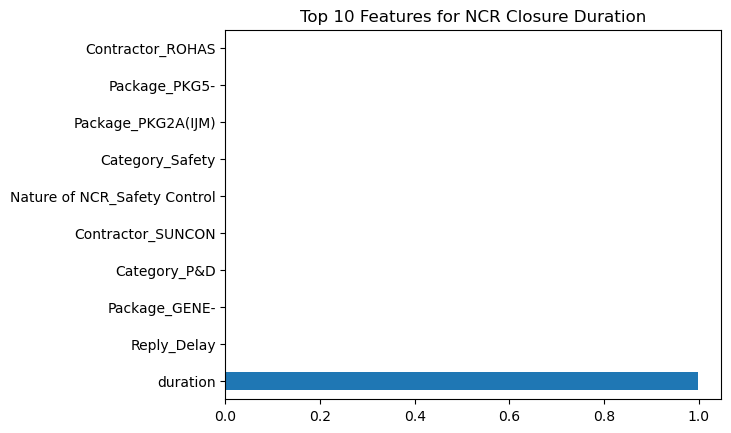

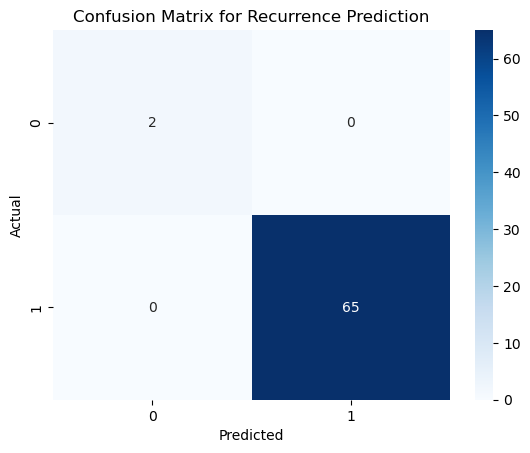

In [16]:
# Feature Importance for Regression
feature_importance = pd.Series(regressor.feature_importances_, index=X_train.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.title('Top 10 Features for NCR Closure Duration')
plt.show()

# Confusion Matrix for Classification
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_recurrence, y_pred_recurrence)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Recurrence Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [17]:
#Other Model - Linear Regression

Mean Absolute Error (MAE) with Linear Regression: 0.00
Top 10 Features and Their Coefficients:
duration                                          1.000000e+00
Nature of NCR_Security                            1.329481e-13
Nature of NCR_Work constructed not per drawing    5.189882e-14
Nature of NCR_TSS reading                         3.930161e-14
Package_PKG6-                                     3.084268e-14
Nature of NCR_Site cleanliness                    2.850877e-14
Package_PKG4-                                     2.257981e-14
Nature of NCR_Environment Control                 2.244231e-14
Package_GENE-                                     2.176925e-14
Package_PKG3-                                     2.003662e-14
dtype: float64


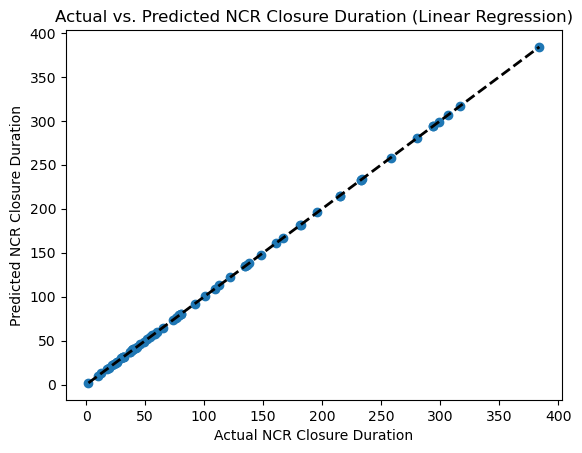

In [18]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pandas as pd


# Impute missing values in Reply_Delay
imputer = SimpleImputer(strategy='mean')
X_train['Reply_Delay'] = imputer.fit_transform(X_train[['Reply_Delay']])
X_test['Reply_Delay'] = imputer.transform(X_test[['Reply_Delay']])

# Initialize and train the Linear Regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train_duration)

# Predict on test data
y_pred_duration_linear = linear_reg.predict(X_test)

# Evaluate the model
mae_linear = mean_absolute_error(y_test_duration, y_pred_duration_linear)
print(f"Mean Absolute Error (MAE) with Linear Regression: {mae_linear:.2f}")

# Interpret the model
coefficients = pd.Series(linear_reg.coef_, index=X_train.columns)
print("Top 10 Features and Their Coefficients:")
print(coefficients.abs().nlargest(10))

# Visualize actual vs. predicted values
plt.scatter(y_test_duration, y_pred_duration_linear)
plt.plot([y_test_duration.min(), y_test_duration.max()], [y_test_duration.min(), y_test_duration.max()], 'k--', lw=2)
plt.xlabel('Actual NCR Closure Duration')
plt.ylabel('Predicted NCR Closure Duration')
plt.title('Actual vs. Predicted NCR Closure Duration (Linear Regression)')
plt.show()

In [19]:
#Other Model - SVR

In [20]:
# Import libraries
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the SVR model
svr = SVR(kernel='rbf')  # Use RBF kernel for non-linear relationships
svr.fit(X_train_scaled, y_train_duration)

# Predict on test data
y_pred_duration_svr = svr.predict(X_test_scaled)

# Evaluate the model
mae_svr = mean_absolute_error(y_test_duration, y_pred_duration_svr)
print(f"Mean Absolute Error (MAE) with SVR: {mae_svr:.2f}")

# Compare with Linear Regression
print(f"MAE with Linear Regression: {mae_linear:.2f}")

Mean Absolute Error (MAE) with SVR: 70.81
MAE with Linear Regression: 0.00


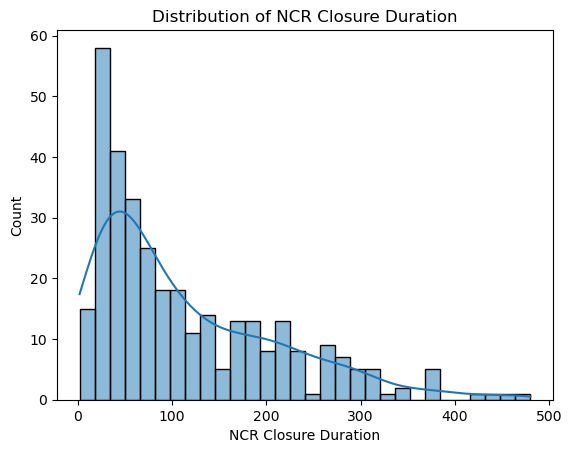

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# NCR Closure Duration distribution
sns.histplot(data['NCR Closure Duration'], bins=30, kde=True)
plt.title("Distribution of NCR Closure Duration")
plt.show()


In [51]:
import joblib
from sklearn.pipeline import Pipeline

# Save models
joblib.dump(regressor, 'models/closure_duration_model.pkl')
joblib.dump(classifier, 'models/recurrence_model.pkl')

['models/recurrence_model.pkl']